# GrabCut

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 1)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 1)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                #print('Draw the rectangle first.')
                pass
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 1, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 1, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 1, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 1, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 1, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 1, self.FLAGS['value']['val'], -1)
                self.FLAGS['rect_or_mask'] = 1

In [20]:
def run(filename, itr, n, fet):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img = cv2.resize(img, (0, 0), fx=0.3, fy=0.3)
    img2 = img.copy()
    im = img.copy()
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown
    X, Y = img.shape[:2]
    gamma=50

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    prev_mask=np.zeros(img.shape[:2], dtype = np.uint8)
    orig_mask=np.zeros(img.shape[:2], dtype = np.uint8)
    
    neighbors4=[
        [-1, 0],
        [0, -1],
        [1, 0],
        [0, 1]
    ]
        
    neighbors8=[
        [-1, 0],
        [0, -1],
        [1, 0],
        [0, 1],
        [-1, -1],
        [-1, 1],
        [1, -1],
        [1, 1]
    ]

    if n==4:
        nghbr=neighbors4[:]
    else:
        nghbr=neighbors8[:]
    
    beta=get_beta(img, X, Y, nghbr)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == ord('s'):
            #im=cv2.hconcat([img, output])
            im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im=cv2.resize(im, (0, 0), fx=2, fy=2)
            plt.figure(figsize=[20, 20])
            plt.imshow(im)
            plt.show()
        
        elif k == 13: 
            im=img
            x, y, w, h=EventObj.FLAGS['RECT']
            if EventObj.FLAGS['rect_or_mask']==0:
                #print("Taking Rectangle Input.")
                temp_mask=np.zeros((X, Y))
                tu=np.ones((h, w))
                temp_mask[y:y+h, x:x+w]=tu
                orig_mask=temp_mask
            else:
                #print("Taking Stroke Input.")
                temp_mask=EventObj.mask
            
            for it in range(itr):
                #print("Iteration:", it+1)
                grph=nx.Graph()
                grph.add_node("bg")
                grph.add_node("fg")
                
                GMM1=GaussianMixture(n_components=fet)
                GMM2=GaussianMixture(n_components=fet)
                
                l1=[]
                l2=[]
                for i in range(X):
                    for j in range(Y):
                        grph.add_node((i, j)) 
                        if temp_mask[i][j]==1:
                            l1.append(img2[i][j])
                        else:
                            l2.append(img2[i][j])
                #print("Fitting GMMs")
                #print("Foreground:", len(l1), "Background:", len(l2))

                GMM1.fit(l1)
                GMM2.fit(l2)

                GMM=[GMM1, GMM2]
                l=[l1, l2]
                #print("Binary Segmentation")
                if EventObj.FLAGS['rect_or_mask']==0:
                    reachable=binary_segmentation(img2, temp_mask, orig_mask, GMM, l, beta, nghbr, grph, X, Y, gamma)
                else:
                    if FLAGS['value'] == DRAW_FG:
                        reachable=binary_segmentation(img2, temp_mask, orig_mask, GMM, l, beta, nghbr, grph, X, Y, gamma, True, prev_mask, True)
                    else:
                        reachable=binary_segmentation(img2, temp_mask, orig_mask, GMM, l, beta, nghbr, grph, X, Y, gamma, True, prev_mask)
                #print("Updating Mask")
                f=0
                temp_mask1=np.zeros((X, Y))
                for item in reachable:
                    if item!="bg":
                        temp_mask1[item[0]][item[1]]=1
                        f=1
                if f==1:
                    temp_mask=temp_mask1
                
                mask2 = np.where((temp_mask == 1), 255, 0).astype('uint8')
                x = cv2.bitwise_and(img2, img2, mask = mask2)
                im = cv2.hconcat([im, x])
            mask=temp_mask
            print("Iterations Completed.")

        EventObj.flags = FLAGS
        EventObj.mask=mask
        prev_mask=mask
        mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

### Functions to compute Beta and also get the actual Minimum Cut from the Graph

In [21]:
def get_beta(img, X, Y, neighbors):
    beta=0
    num_ed=0
    for i in range(X):
        for j in range(Y):
            for ne in neighbors:
                i_ne, j_ne=ne
                dif=0
                if (i+i_ne>=0 and i+i_ne<X) and (j+j_ne>=0 and j+j_ne<Y):
                    dif=img[i][j]-img[i+i_ne][j+j_ne]
                    dif=dif**2
                    dif=np.sum(dif)
                    num_ed+=1
                beta+=dif
    beta=num_ed/(2*beta)
    return(beta)
    
def binary_segmentation(img, mask, o_mask, GMM, l, beta, neighbors, grph, X, Y, gamma, flag=False, prev_mask=None, fg=False):
    #print("Adding Edges")
    for i in range(X):
        for j in range(Y):
            #COMPUTE NEGATIVE LOG LIKELIHOOD FOR PIXEL
            score=[0, 0]
            for x in range(2):
                val=img[i][j].reshape(1, -1)
                idx=GMM[x].predict(val)[0]
                cv=GMM[x].covariances_[idx]
                mn=GMM[x].means_[idx]
                wt=GMM[x].weights_[idx]
                d=val-mn
                sc=-np.log(wt)
                sc+=0.5*np.log(np.linalg.det(cv))
                sc+=0.5*np.dot(d, np.dot(np.linalg.inv(cv), d.T))
                score[x]=sc
            #ADD EDGES TO FG/BG
            #CASE FOR FG STROKE
            if flag and fg:
                if mask[i][j]==0:
                    if prev_mask[i][j]==0 and o_mask[i][j]==1:
                        grph.add_edge("bg", (i, j), capacity=score[1])
                        grph.add_edge((i, j), "fg", capacity=score[0])
                    else:
                        grph.add_edge("bg", (i, j), capacity=0)
                        grph.add_edge((i, j), "fg")
                else:
                    if flag and prev_mask[i][j]==1:
                        grph.add_edge("bg", (i, j))
                        grph.add_edge((i, j), "fg", capacity=0)
                    else:
                        grph.add_edge("bg", (i, j), capacity=score[1])
                        grph.add_edge((i, j), "fg", capacity=score[0])
            #CASE FOR BG STROKE/RECTANGLE INPUT
            else:
                if mask[i][j]==0:
                    grph.add_edge("bg", (i, j), capacity=0)
                    grph.add_edge((i, j), "fg")
                else:
                    grph.add_edge("bg", (i, j), capacity=score[1])
                    grph.add_edge((i, j), "fg", capacity=score[0])
            #ADD EDGES TO NEIGHBORS        
            for x in neighbors:
                i_ne, j_ne=x
                if (i+i_ne>=0 and i+i_ne<X) and (j+j_ne>=0 and j+j_ne<Y):
                    dif=img[i][j]-img[i+i_ne][j+j_ne]
                    dif=dif**2
                    dif=np.sum(dif)
                    val=gamma*np.exp(-beta*dif)
                    grph.add_edge((i, j), (i+i_ne, j+j_ne), capacity=val)
    #print("Running MinCut")
    _, partition=nx.minimum_cut(grph, "bg", "fg", flow_func=shortest_augmenting_path)
    reachable, _=partition
    return(reachable)

In [22]:
def grabcut(filename, itr, ngh, c):
    run(filename, itr, ngh, c)
    cv2.destroyAllWindows()

## Testing with iterations upto 5, neighbors=4, GMM components=2

Iterations Completed.


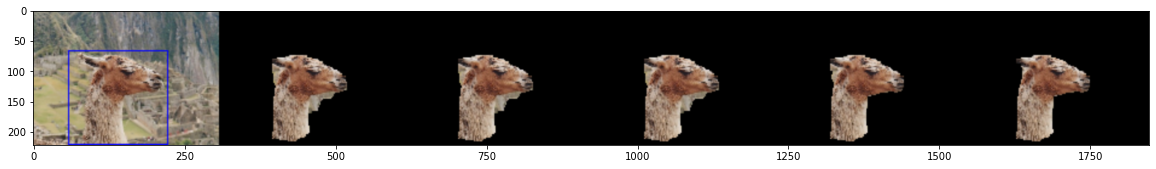

Iterations Completed.


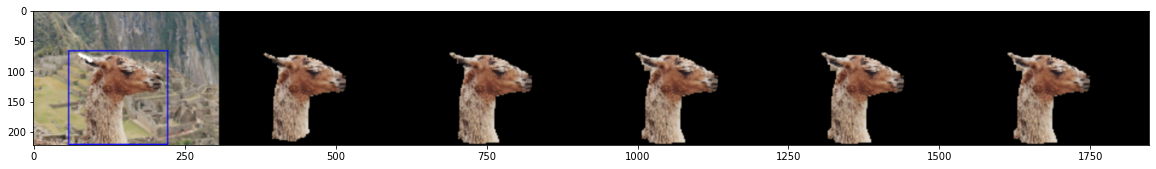

In [23]:
grabcut('../images/llama.jpg', 5, 4, 2)

Iterations Completed.


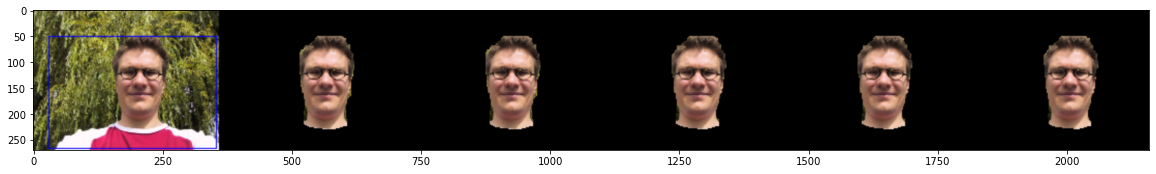

Iterations Completed.


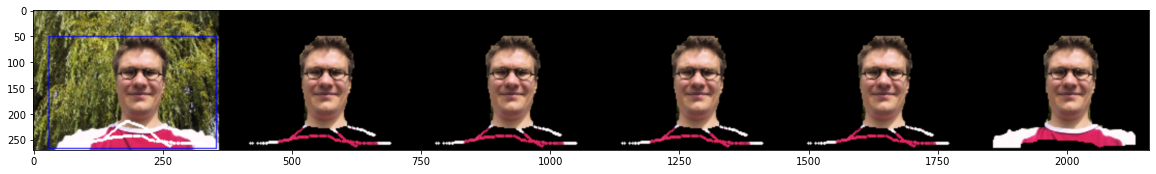

Iterations Completed.


In [24]:
grabcut('../images/person1.jpg', 5, 4, 2)

Iterations Completed.


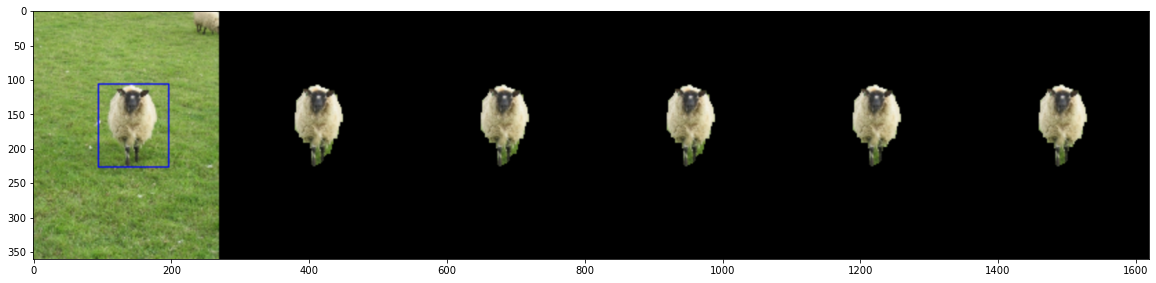

In [25]:
grabcut('../images/sheep.jpg', 5, 4, 2)

Iterations Completed.


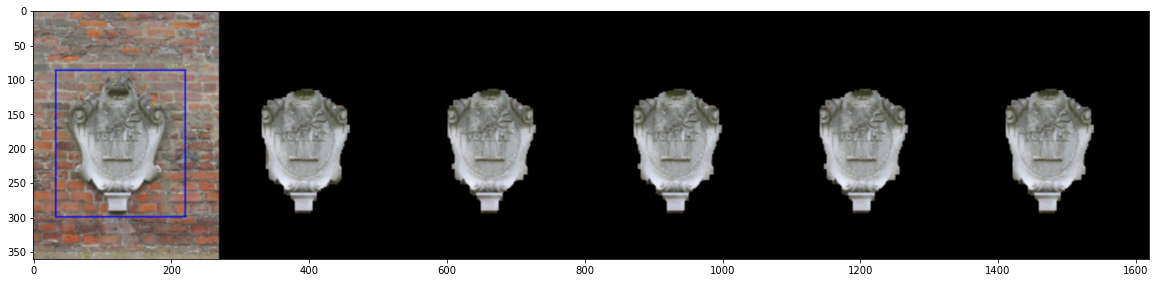

Iterations Completed.


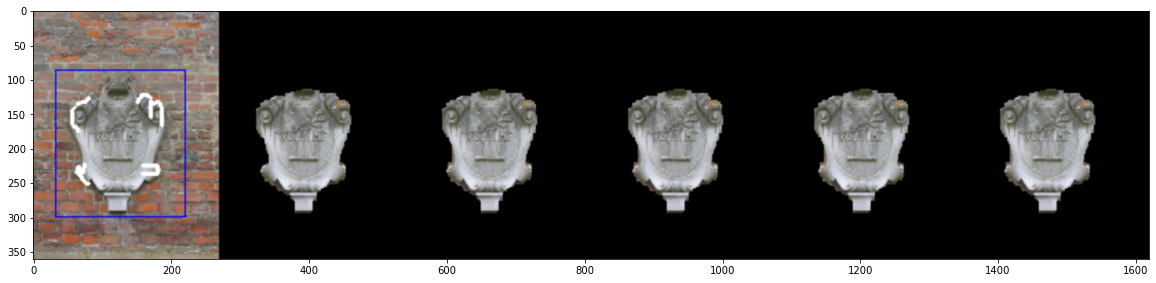

Iterations Completed.


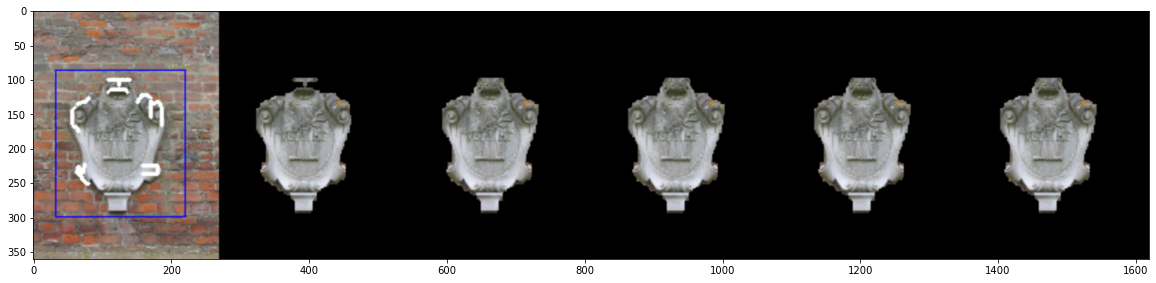

In [26]:
grabcut('../images/memorial.jpg', 5, 4, 2)

Iterations Completed.


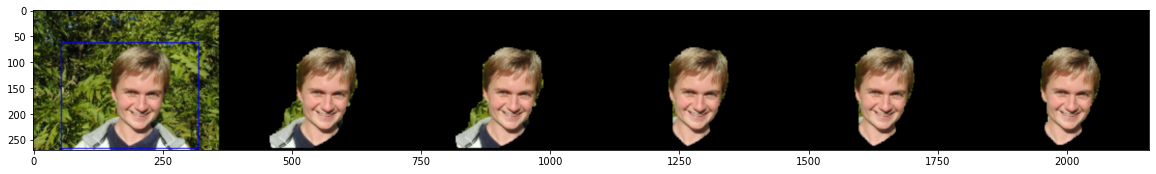

Iterations Completed.


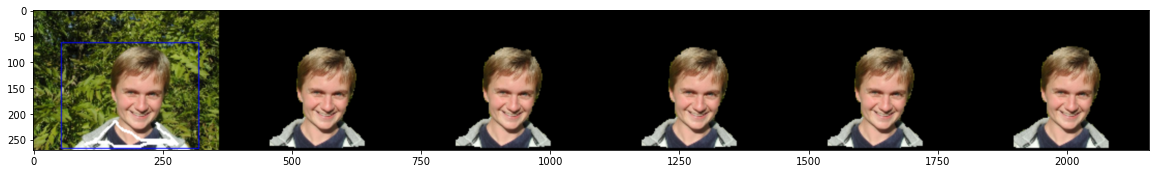

In [28]:
grabcut('../images/person2.jpg', 5, 4, 2)

## Testing with iterations upto 5, neighbors=8, GMM components=2

Iterations Completed.


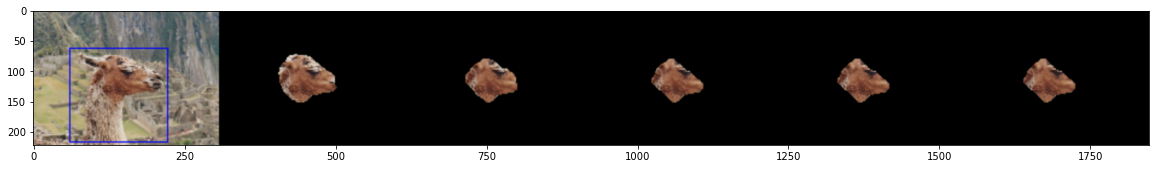

Iterations Completed.


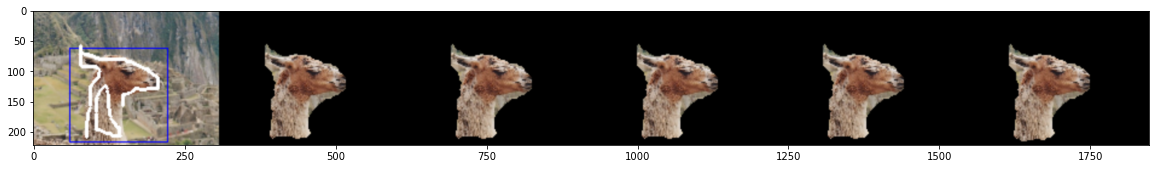

Iterations Completed.


In [29]:
grabcut('../images/llama.jpg', 5, 8, 2)

Iterations Completed.


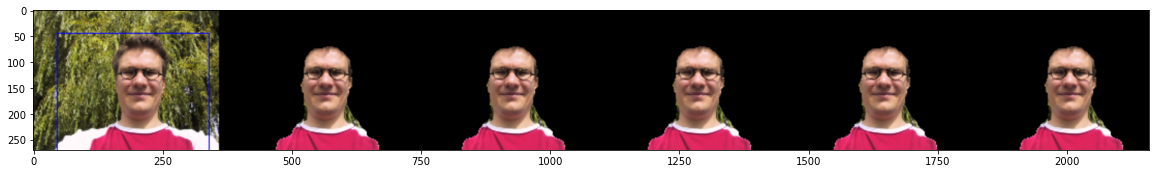

Iterations Completed.


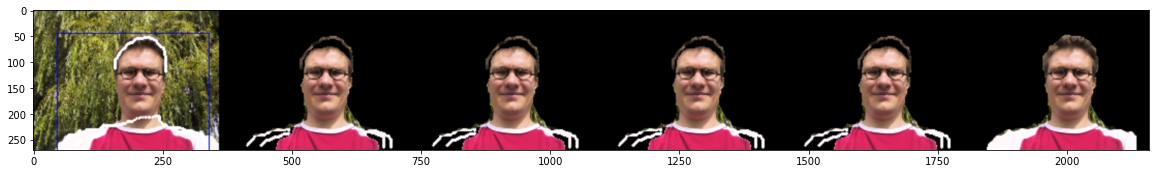

In [32]:
grabcut('../images/person1.jpg', 5, 8, 2)

Iterations Completed.


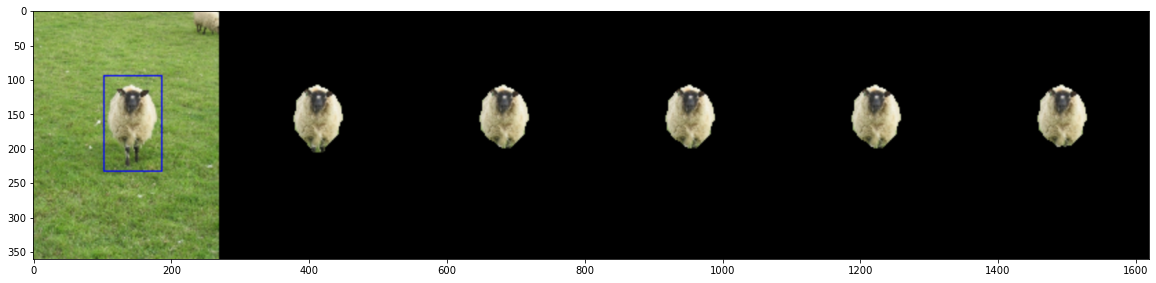

Iterations Completed.


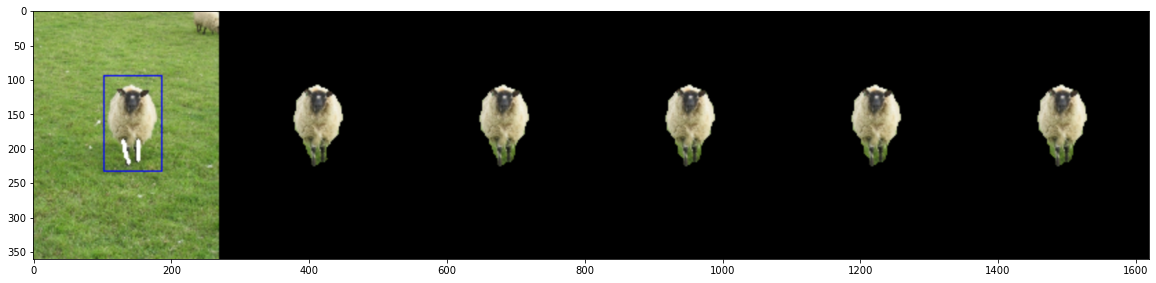

In [35]:
grabcut('../images/sheep.jpg', 5, 8, 2)

## Testing for iterations upto 5, neighbors=4, GMM components=5

Iterations Completed.


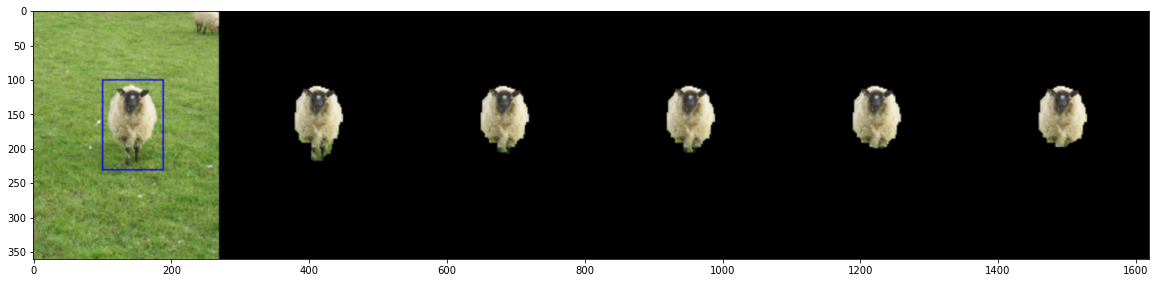

Iterations Completed.


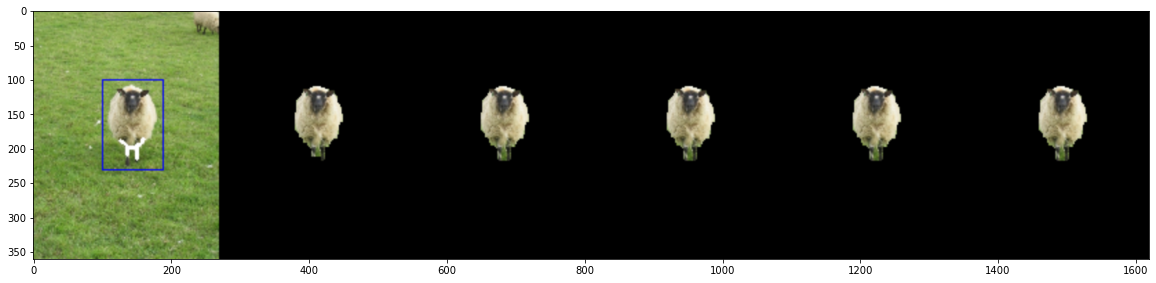

In [36]:
grabcut('../images/sheep.jpg', 5, 4, 5)

Iterations Completed.


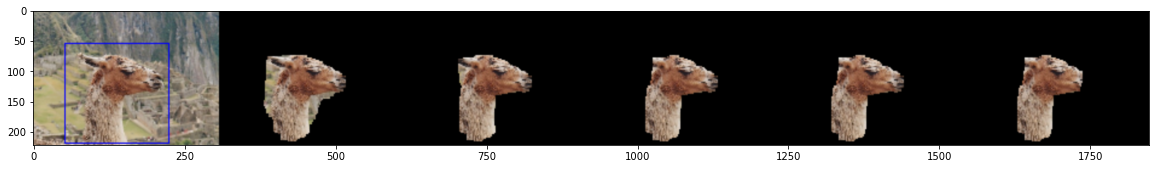

Iterations Completed.


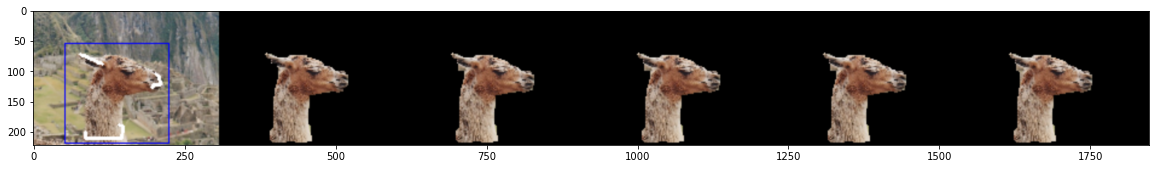

In [37]:
grabcut('../images/llama.jpg', 5, 4, 5)

Iterations Completed.


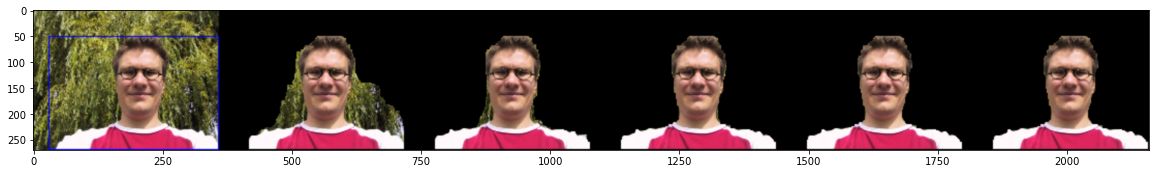

In [38]:
grabcut('../images/person1.jpg', 5, 4, 5)

## Testing for iterations upto 5, neighbors=8, GMM components=5

Iterations Completed.


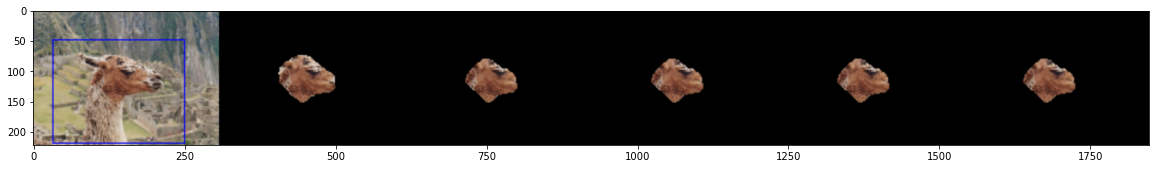

Iterations Completed.


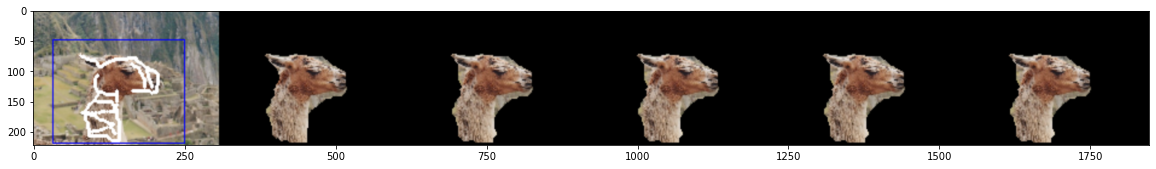

In [46]:
grabcut('../images/llama.jpg', 5, 8, 5)

Iterations Completed.


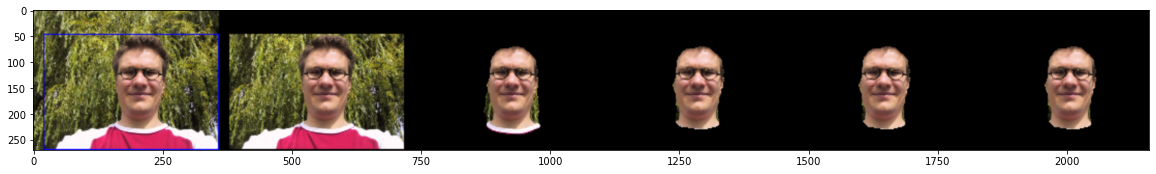

Iterations Completed.


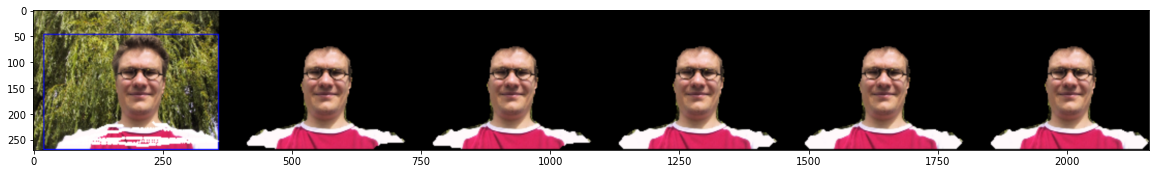

Iterations Completed.


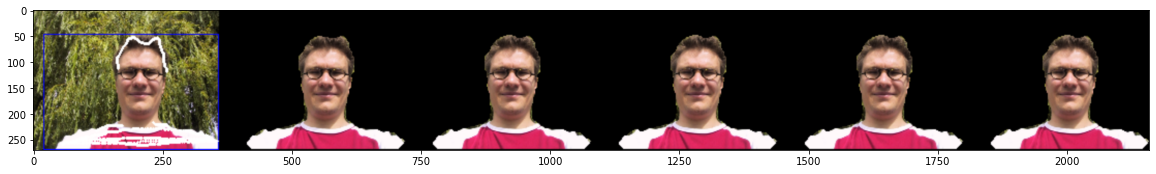

In [47]:
grabcut('../images/person1.jpg', 5, 8, 5)

Iterations Completed.


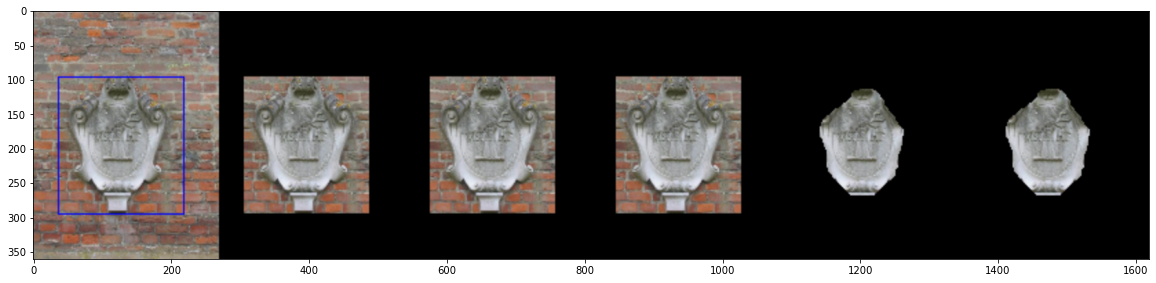

Iterations Completed.


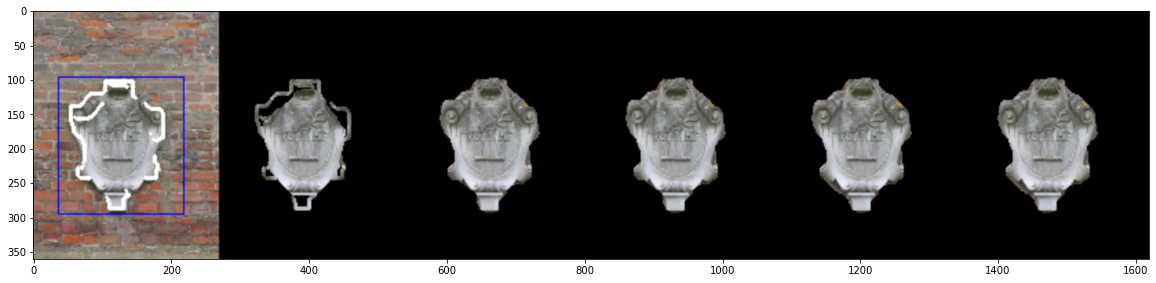

In [50]:
grabcut('../images/memorial.jpg', 5, 8, 5)

# Results

1. For varying number of iterations, I found out-
    * With every iteration, for rectangle input, the FG either remains the same or decreases.
    * As the iterations increase, more and more pixels get removed from the FG.
    * Ideally number of iterations suggested was 5 in the paper, but I found out that for certain images the convergence was acheived by iteration 2-3 only, whereas for other images the convergence might take more than 5 iterations to be acheived.
    * For images with stroke input, with number of iterations increasing the output becomes more and more aligned with/correct segementation occurs.
    * Hence conclusion would be that with increase in iterations the accuracy tends to increase.

2. For varying number of neighbors, I found out-
    * For 4 neighbors, the algorithm seemed to work quite well, the results were more likely to have correct pixels without the need of user interaction to improve the result in further iterations.
    * For 4 neighbors, the algorithm does not aggresively remove pixels from FG.
    * For 8 neighbors, the algorithm seemed to be more aggresive in removing the pixels from the FG.
    * In the case of 8 neighbors, the need of user input as strokes was quite evident and required in almost all the cases, without which the output was just not acceptable enough.

3. For varying number of GMM components, I found out-
    * For GMM components=2, the results were quite accurate, with the algorithm being just correct and seemed to work good with least amount of user intervention.
    * For GMM components=5, the algorithm seemed to be less accurate, and more eager to remove the pixels from FG to BG.

## Finally the best output seemed to be when number of iterations was upto 5, number of neighbors was 4 and number of GMM components was 2.

Iterations Completed.


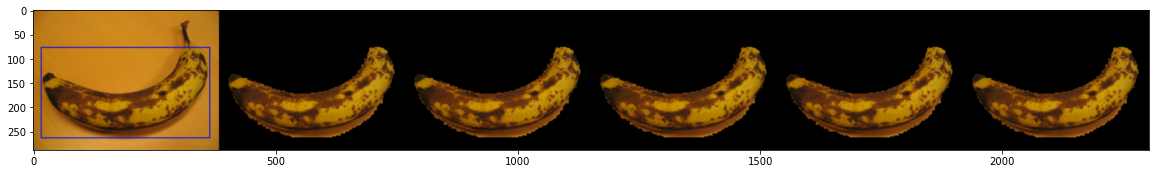

Iterations Completed.


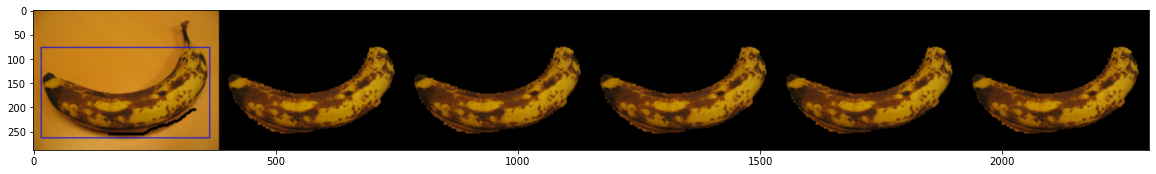

In [52]:
grabcut('../images/banana1.jpg', 5, 4, 2)